# Logistic Regression

In [20]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve,
    precision_recall_curve, auc
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# set random seed for reproducibility
np.random.seed(42)

## Baseline Logistic Regression

In [21]:
# load train/test data
X_train_smote = pd.read_csv("../data/X_train_smote.csv")
y_train_smote = pd.read_csv("../data/y_train_smote.csv").values.ravel()
X_test_processed = pd.read_csv("../data/X_test_processed.csv")
y_test = pd.read_csv("../data/y_test.csv").values.ravel()

In [22]:
# remove leaky features
leaky_features = ['max_delay', 'avg_delay', 'num_bad_months', 'months_total']
X_train_smote_clean = X_train_smote.drop(columns=leaky_features, errors='ignore')
X_test_processed_clean = X_test_processed.drop(columns=leaky_features, errors='ignore')

In [23]:
# create scaler instance
scaler = StandardScaler()

# fit on train, transform both train and test
X_train_scaled = scaler.fit_transform(X_train_smote_clean) 
X_test_scaled = scaler.transform(X_test_processed_clean) 

# instantiate model training
model = LogisticRegression(max_iter=1000) 

model.fit(X_train_scaled, y_train_smote) 
y_pred = model.predict(X_test_scaled)

### Evaluation

In [24]:
# predicted probabilities (for AUC/ROC)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# print key metrics
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba):.4f}")

# confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# classification report (shows all classes)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Accuracy:  0.5235
Precision: 0.0200
Recall:    0.4914
F1-score:  0.0383
ROC-AUC:   0.5530

Confusion Matrix:
[[3084 2800]
 [  59   57]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9812    0.5241    0.6833      5884
           1     0.0200    0.4914    0.0383       116

    accuracy                         0.5235      6000
   macro avg     0.5006    0.5078    0.3608      6000
weighted avg     0.9626    0.5235    0.6708      6000



ROC AUC Score: 0.553


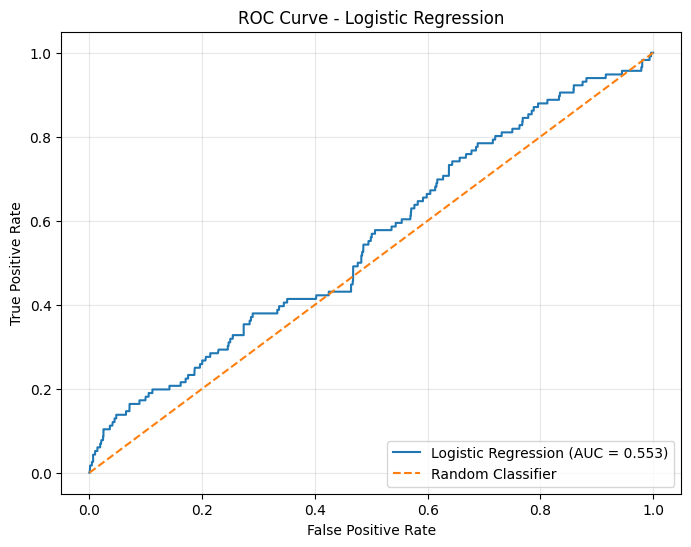

In [25]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {auc_score:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

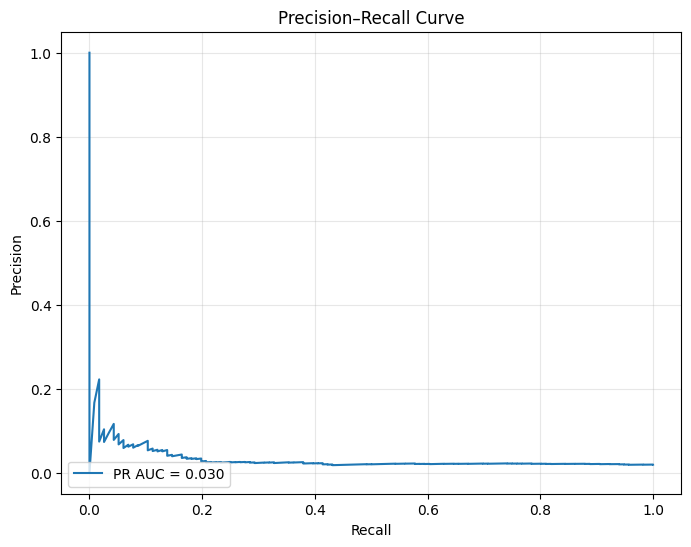

In [26]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

## Stepwise Model Improvement

### Tune Decision Threshold

In [27]:
# threshold sweep
thresholds = np.arange(0.0, 1.01, 0.05)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))

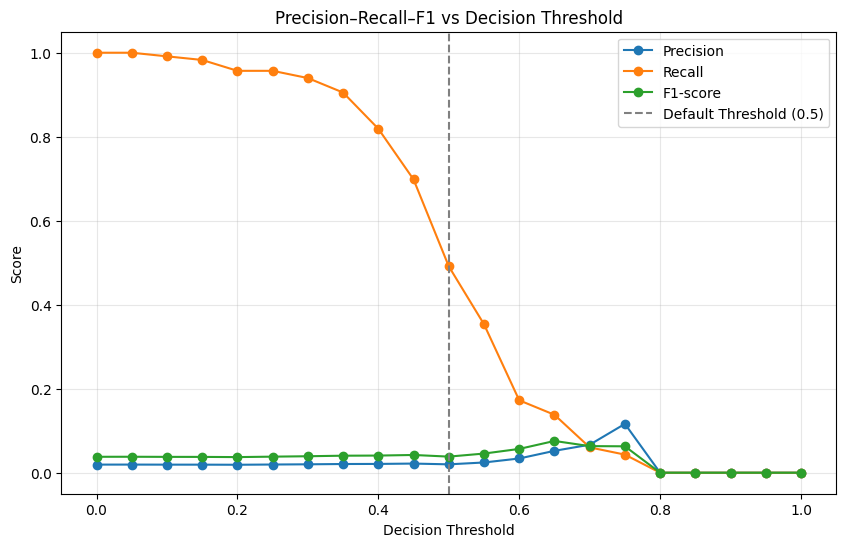

In [28]:
# plot precision / recall / f1
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", marker='o')
plt.plot(thresholds, recalls, label="Recall", marker='o')
plt.plot(thresholds, f1s, label="F1-score", marker='o')
plt.axvline(0.5, color='grey', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall–F1 vs Decision Threshold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [29]:
# find best f1
best_idx = np.argmax(f1s)
print(f"Best F1-score: {f1s[best_idx]:.4f} at threshold = {thresholds[best_idx]:.2f}")


Best F1-score: 0.0757 at threshold = 0.65


In [30]:
# re-evaluate at best threshold 
best_thresh = thresholds[best_idx]
y_pred_best = (y_proba >= best_thresh).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report (best threshold):")
print(classification_report(y_test, y_pred_best, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


Classification Report (best threshold):
              precision    recall  f1-score   support

           0     0.9824    0.9505    0.9662      5884
           1     0.0521    0.1379    0.0757       116

    accuracy                         0.9348      6000
   macro avg     0.5173    0.5442    0.5209      6000
weighted avg     0.9644    0.9348    0.9490      6000


Confusion Matrix:
 [[5593  291]
 [ 100   16]]


#### Cross-Validated Threshold Optimization

In [31]:
# setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
thresholds = np.arange(0.0, 1.01, 0.05)

f1_scores_per_thresh = np.zeros((len(thresholds), kf.get_n_splits()))
best_thresholds = []
auc_scores = []

In [32]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled, y_train_smote), start=1):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train_smote[train_idx], y_train_smote[val_idx]
    
    model_cv = LogisticRegression(max_iter=1000, random_state=42)
    model_cv.fit(X_tr, y_tr)
    
    y_val_proba = model_cv.predict_proba(X_val)[:, 1]
    auc_scores.append(roc_auc_score(y_val, y_val_proba))
    
    # compute F1 across thresholds
    for i, t in enumerate(thresholds):
        y_val_pred = (y_val_proba >= t).astype(int)
        f1_scores_per_thresh[i, fold - 1] = f1_score(y_val, y_val_pred, zero_division=0)
    
    # best threshold for this fold
    best_idx = np.argmax(f1_scores_per_thresh[:, fold - 1])
    best_thresholds.append(thresholds[best_idx])
    print(f"Fold {fold} best threshold = {thresholds[best_idx]:.2f}, F1 = {f1_scores_per_thresh[best_idx, fold - 1]:.4f}")

Fold 1 best threshold = 0.35, F1 = 0.6853
Fold 2 best threshold = 0.35, F1 = 0.6813
Fold 3 best threshold = 0.35, F1 = 0.6851
Fold 4 best threshold = 0.35, F1 = 0.6836
Fold 5 best threshold = 0.35, F1 = 0.6835


In [33]:
# summary
mean_f1 = f1_scores_per_thresh.mean(axis=1)
best_overall_idx = np.argmax(mean_f1)
best_overall_thresh = thresholds[best_overall_idx]

print(f"Mean ROC-AUC across folds: {np.mean(auc_scores):.4f}")
print(f"Best average threshold: {best_overall_thresh:.2f}")
print(f"Average best F1-score: {mean_f1[best_overall_idx]:.4f}")

Mean ROC-AUC across folds: 0.6173
Best average threshold: 0.35
Average best F1-score: 0.6837


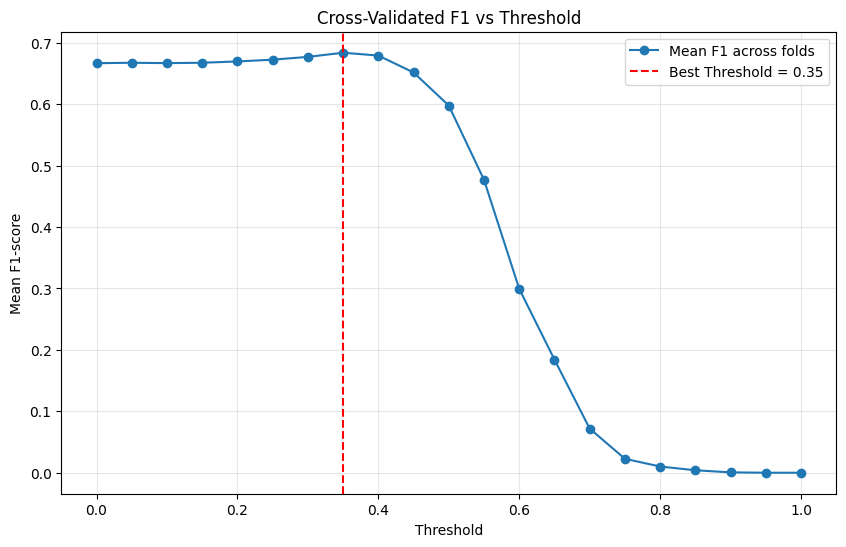

In [34]:
# plot
plt.figure(figsize=(10,6))
plt.plot(thresholds, mean_f1, marker='o', label='Mean F1 across folds')
plt.axvline(best_overall_thresh, color='red', linestyle='--', label=f'Best Threshold = {best_overall_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Mean F1-score')
plt.title('Cross-Validated F1 vs Threshold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Threshold Optimization Analysis**

After fitting the baseline logistic regression model, we examined how varying the **classification threshold** affects performance on an imbalanced credit-risk dataset.

At the default threshold of 0.5, the model produces high recall but very low precision.  
It predicts many defaults that are actually non-defaults, leading to numerous false positives.  
This is common for imbalanced data—accuracy is misleading because most cases belong to the majority (non-default) class.

To better understand the trade-off, we evaluated **Precision**, **Recall**, and **F1-Score** over thresholds from 0.0 → 1.0.

- As the threshold **increased**, the model became **more conservative**, predicting fewer defaults (↓ recall, ↑ precision).  
- As the threshold **decreased**, the model became **more liberal**, catching more defaults but also generating more false alarms.

The F1 curve peaked at:

> **Best F1 = 0.0757 at threshold = 0.65**

This higher threshold improves precision slightly but sharply reduces recall.  
It indicates that a stricter decision boundary reduces false positives but risks missing more true defaulters.

Using Stratified K-Fold cross-validation on the SMOTE-balanced training data:

| Fold | Best Threshold | F1 |
|:--|:--|:--|
| 1 | 0.35 | 0.6853 |
| 2 | 0.35 | 0.6813 |
| 3 | 0.35 | 0.6851 |
| 4 | 0.35 | 0.6836 |
| 5 | 0.35 | 0.6835 |

The **mean best threshold ≈ 0.35**, with consistently high F1-scores.  
However, these results are optimistic because the SMOTE training set is artificially balanced (50 % / 50 %), unlike the highly imbalanced real-world data (~2 % defaults).

| Scenario | Data Balance | Best Threshold | Comment |
|:--|:--|:--|:--|
| Cross-Validation | Balanced (SMOTE) | **0.35** | Optimistic — model sees equal classes |
| Test Set | Imbalanced (real) | **0.65** | Realistic — reflects production conditions |

- In the **balanced** CV setting, a lower threshold (0.35) performs best because the model can safely predict more positives.  
- In the **real** imbalanced test data, a higher threshold (0.65) is required to control false positives.

For realistic deployment on genuine credit-risk data:

> **Use threshold ≈ 0.65**

This threshold provides a more reliable trade-off between detecting actual defaulters and avoiding unnecessary rejections of good applicants.

If the goal shifts toward maximizing recall (catching as many defaulters as possible), the threshold can be **lowered** (e.g., 0.3–0.4), but this will increase false positives.

### Regularization and Hyperparameter Tuning

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train_smote)
print("Best parameters:", grid.best_params_)
print("Best cross-validated ROC-AUC:", grid.best_score_)

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validated ROC-AUC: 0.6170028050204495


In [40]:
# retrain model on new parameters
model_tuned = LogisticRegression(
    C=10,
    penalty='l2',
    solver='saga',
    max_iter=1000,
    random_state=42
)
model_tuned.fit(X_train_scaled, y_train_smote)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'saga'
,max_iter,1000
,multi_class,'deprecated'


In [41]:
# evaluate
y_proba_tuned = model_tuned.predict_proba(X_test_scaled)[:, 1]
y_pred_tuned = (y_proba_tuned >= 0.65).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print(f"Test ROC-AUC: {roc_auc_score(y_test, y_proba_tuned):.4f}")
print("\nClassification Report (Threshold = 0.65):")
print(classification_report(y_test, y_pred_tuned, digits=4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))

Test ROC-AUC: 0.5531

Classification Report (Threshold = 0.65):
              precision    recall  f1-score   support

           0     0.9824    0.9504    0.9661      5884
           1     0.0519    0.1379    0.0755       116

    accuracy                         0.9347      6000
   macro avg     0.5172    0.5442    0.5208      6000
weighted avg     0.9644    0.9347    0.9489      6000


Confusion Matrix:
[[5592  292]
 [ 100   16]]


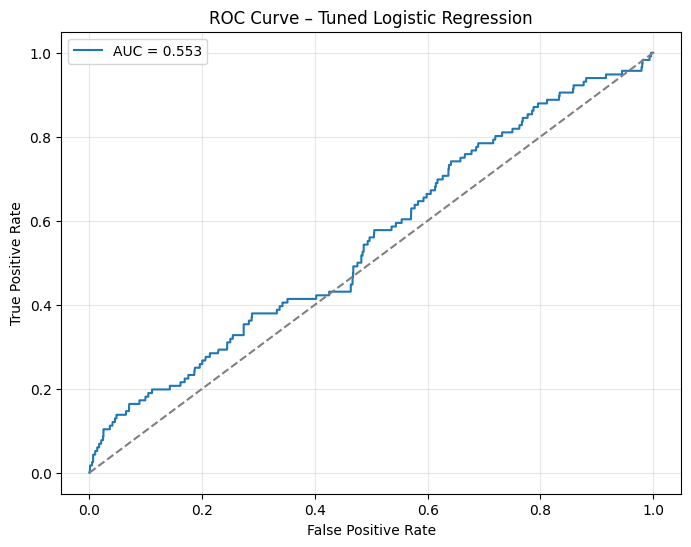

In [42]:
# roc curve
fpr, tpr, _ = roc_curve(y_test, y_proba_tuned)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba_tuned):.3f}')
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Tuned Logistic Regression')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### `class_weight='balanced'` instead of SMOTE

In [66]:
# load pre-SMOTE data
X_train_clean = pd.read_csv("../data/X_train_processed.csv")
y_train_clean = pd.read_csv("../data/y_train.csv").values.ravel()   # if you saved as y_train_clean.csv, change here

# load test data
X_test_processed = pd.read_csv("../data/X_test_processed.csv")
y_test = pd.read_csv("../data/y_test.csv").values.ravel()

print(X_train_clean.shape)
print(y_train_clean.shape)
print(X_test_processed.shape)
print(y_test.shape)

(23996, 51)
(23996,)
(6000, 51)
(6000,)


In [67]:
# debugging
print(X_train_clean.dtypes.head())
print(X_test_processed.dtypes.head())

# convert both to numpy arrays for consistent type
X_train_array = np.array(X_train_clean, dtype=float)
X_test_array = np.array(X_test_processed, dtype=float)

age                float64
years_employed     float64
amt_income_log     float64
cnt_children       float64
cnt_fam_members    float64
dtype: object
age                float64
years_employed     float64
amt_income_log     float64
cnt_children       float64
cnt_fam_members    float64
dtype: object


In [70]:
# remove leaky features
leaky_features = ['max_delay', 'avg_delay', 'num_bad_months', 'months_total']

X_train_clean = X_train_clean.drop(columns=leaky_features, errors='ignore')
X_test_processed = X_test_processed.drop(columns=leaky_features, errors='ignore')

In [72]:
# train class-weighted logistic regression
model_bal = LogisticRegression(
    C=10,
    penalty='l2',
    solver='saga',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
model_bal.fit(X_train_clean, y_train_clean)

# predict
y_proba_bal = model_bal.predict_proba(X_test_processed)[:, 1]
y_pred_bal = (y_proba_bal >= 0.65).astype(int)

/Users/loowenwen/Desktop/GitHub/cs3244-project/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [73]:
# evaluate
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_proba_bal):.4f}")
print("\nClassification Report (Threshold = 0.65):")
print(classification_report(y_test, y_pred_bal, digits=4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_bal))

Test ROC-AUC: 0.5858

Classification Report (Threshold = 0.65):
              precision    recall  f1-score   support

           0     0.9821    0.9531    0.9674      5884
           1     0.0483    0.1207    0.0690       116

    accuracy                         0.9370      6000
   macro avg     0.5152    0.5369    0.5182      6000
weighted avg     0.9641    0.9370    0.9500      6000


Confusion Matrix:
[[5608  276]
 [ 102   14]]


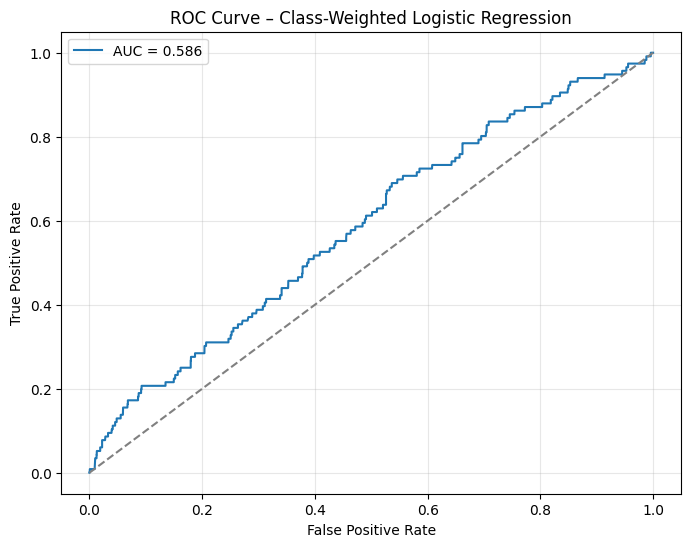

In [74]:
# roc curve
fpr, tpr, _ = roc_curve(y_test, y_proba_bal)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba_bal):.3f}')
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Class-Weighted Logistic Regression')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Feature Engineering

In [ ]:
# feature engineering
def credit_features(df):
    df = df.copy()

    # income per family member
    if {"amt_income_total", "cnt_fam_members"}.issubset(df.columns):
        df["fe_income_per_head"] = df["amt_income_total"] / (df["cnt_fam_members"])

    # car and realty ownership
    if {"flag_own_car", "flag_own_realty"}.issubset(df.columns):
        df["fe_car_and_house"] = ((df["flag_own_car"] == 1) & (df["flag_own_realty"] == 1)).astype(int)

    # income per child
    if {"amt_income_total", "cnt_children"}.issubset(df.columns):
        df["fe_income_per_child"] = df["amt_income_total"] / (df["cnt_children"])

    return df


In [78]:
X_train_smote_clean = X_train_smote.drop(columns=leaky_features, errors='ignore')
X_test_processed_clean = X_test_processed.drop(columns=leaky_features, errors='ignore')

X_train_fe = credit_features(X_train_smote_clean)
X_test_fe = credit_features(X_test_processed_clean)

X_train_scaled = scaler.fit_transform(X_train_fe)
X_test_scaled = scaler.transform(X_test_fe)

model = LogisticRegression(max_iter=100, class_weight='balanced')
model.fit(X_train_scaled, y_train_smote)

y_proba = model.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC after feature engineering: {auc_score:.3f}")


AUC after feature engineering: 0.553
